In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [21]:
!pip install torchinfo

In [22]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from torchvision import transforms
image_path="../input/rice-leaf-images/rice_images"
train_transforms=transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(255),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])


test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [25]:
from torchvision.datasets import ImageFolder
dataset=ImageFolder(image_path,transform=train_transforms)
img,label=dataset[0]
print(img.shape,label)
print(dataset.classes)


torch.Size([3, 224, 224]) 0
['_BrownSpot', '_Healthy', '_Hispa', '_LeafBlast']


label:  _BrownSpot (0)


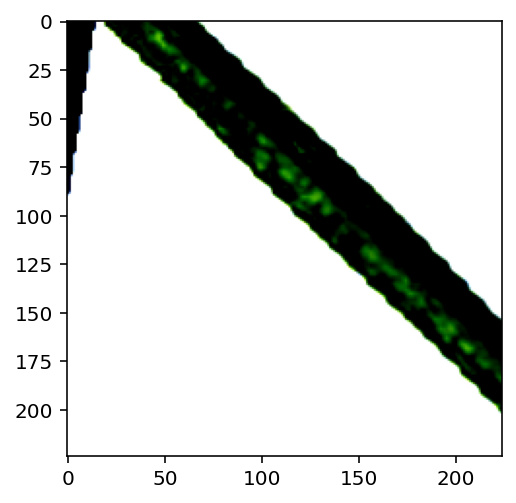

In [26]:
import matplotlib.pyplot as plt
def show_example(img,label):
    print("label: ",dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
show_example(*dataset[0])    

# Training,validation,test data set split

In [27]:
import numpy as np
def split_indices(n,val_pct=0.1,test_pct=0.2,seed=99):
    n_val=int(val_pct*n)
    n_test=int(test_pct*n)
    np.random.seed(seed)
    idxs=np.random.permutation(n)
    return idxs[:n_val],idxs[n_val:n_val+n_test],idxs[n_val+n_test:]
val_pct=0.15
test_pct=0.15
rand_seed=42
valid_indices,test_indices,train_indices=split_indices(len(dataset),val_pct,test_pct,rand_seed)

In [28]:
print("test_size",len(test_indices))
print("validiti_size",len(valid_indices))
print("train_size",len(train_indices))

test_size 503
validiti_size 503
train_size 2349


In [29]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader


In [30]:
batch_size=32
train_sampler=SubsetRandomSampler(train_indices)
valid_sampler=SubsetRandomSampler(valid_indices)
test_sampler=SubsetRandomSampler(test_indices)

In [31]:
train_dl=DataLoader(dataset,batch_size,sampler=train_sampler)
valid_dl=DataLoader(dataset,batch_size,sampler=valid_sampler)
test_dl=DataLoader(dataset,batch_size,sampler=test_sampler)

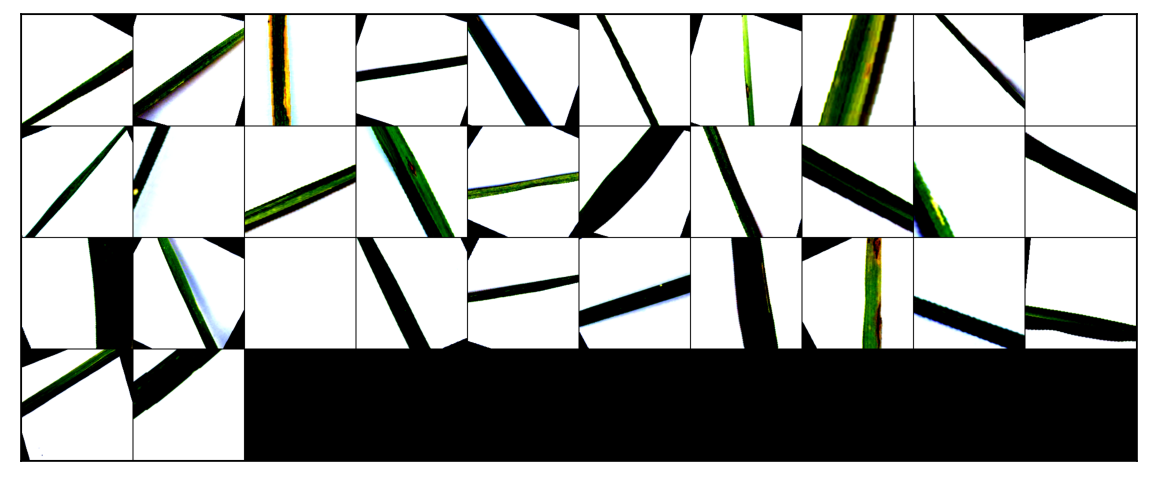

In [32]:
from torchvision.utils import make_grid
def show_batch(dl):
    for image,label in dl:
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(image,10).permute(1,2,0))
        break
show_batch(train_dl)        

In [33]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def train_model(model,train_dl,valid_dl,epochs,print_every,criterian,opt,device="cpu"):
    steps=0
    model.to(device)
    for e in range(epochs):
        running_loss=0
        for ii,(images,labels) in enumerate(train_dl):
            
            steps += 1

            images, labels = images.to(device), labels.to(device)

            opt.zero_grad()

            # Forward and backward passes
            outputs = model.forward(images)
            loss =criterian(outputs, labels)
            loss.backward()
            opt.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                valid_accuracy = validation(valid_dl,device)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Accuracy: {}".format(round(valid_accuracy,4)))

                running_loss = 0

In [ ]:
def validation(valid_dl,model,device="cpu"):
    correct=total=0
    with torch.no_grad():
        for images,labels in valid_dl:
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            _,pred=torch.max(output.data,1)
            total+=labels.size(0)
            correct+=(pred==labels).sum().item()
    return (correct/total)*100  

In [34]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier =nn.Sequential(OrderedDict([
            ("fc1",nn.Linear(9216,4096))
            ,("relu1",nn.ReLU()),
            ("d1",nn.Dropout(0.2)),
                ("fc2",nn.Linear(4096,1024))
            ,("relu2",nn.ReLU()),
            ("d2",nn.Dropout(0.2)),
            ("fc3",nn.Linear(1024,102)),
            ('output', nn.LogSoftmax(dim=1))
            ]))

    
model.classifier = classifier

In [ ]:
opt=optim.SGD(model.classifier.parameters(), lr=0.0001, momentum=0.9)
train_model(model,train_dl,valid_dl,6,30,nn.NLLLoss(),opt,device)

In [ ]:
test_accuracy = validation(test_dl,model,device)
print("test Accuracy: desnet121 {}".format(round(test_accuracy,4)))

In [35]:
# model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [36]:
import time

In [38]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(25088, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 4),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [39]:
# import torch
# from torchvision.models import resnet50, ResNet50_Weights
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = resnet50(weights=ResNet50_Weights.DEFAULT)

# # Freeze parameters so we don't backprop through them
# for param in model.parameters():
#     param.requires_grad = False
    
# model.classifier = nn.Sequential(nn.Linear(25088, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(1024, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 4),
#                                  nn.LogSoftmax(dim=1))

# criterion = nn.NLLLoss()

# # Only train the classifier parameters, feature parameters are frozen
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

ImportError: cannot import name 'ResNet50_Weights' from 'torchvision.models' (/opt/conda/lib/python3.7/site-packages/torchvision/models/__init__.py)

In [40]:
# model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=256, out_features=4, bias=True)
  (7): LogSoftmax(dim=1)
)

In [41]:
# print(device)
# model.to(device)
# epochs = 10
# steps = 0
# running_loss = 0
# print_every = 5
# for epoch in range(epochs):
#     ii=1
#     for inputs, labels in train_dl:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model.eval()
#             with torch.no_grad():
                
#                 for inputs, labels in valid_dl:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model.forward(inputs)
#                     batch_loss = criterion(logps, labels)
                    
#                     test_loss += batch_loss.item()
                    
#                     # Calculate accuracy
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
#             print(f"Epoch {epoch+1}/{epochs} batch-{ii}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(valid_dl):.3f}.. "
#                   f"Test accuracy: {accuracy/len(valid_dl):.3f}")
#             running_loss = 0
#             ii+=1
#             model.train()

cuda
Epoch 1/10 batch-1.. Train loss: 1.514.. Test loss: 1.432.. Test accuracy: 0.443
Epoch 1/10 batch-2.. Train loss: 1.391.. Test loss: 1.465.. Test accuracy: 0.429
Epoch 1/10 batch-3.. Train loss: 1.290.. Test loss: 1.328.. Test accuracy: 0.441
Epoch 1/10 batch-4.. Train loss: 1.347.. Test loss: 1.336.. Test accuracy: 0.426
Epoch 1/10 batch-5.. Train loss: 1.293.. Test loss: 1.250.. Test accuracy: 0.447
Epoch 1/10 batch-6.. Train loss: 1.336.. Test loss: 1.277.. Test accuracy: 0.437
Epoch 1/10 batch-7.. Train loss: 1.221.. Test loss: 1.320.. Test accuracy: 0.445
Epoch 1/10 batch-8.. Train loss: 1.256.. Test loss: 1.292.. Test accuracy: 0.455
Epoch 1/10 batch-9.. Train loss: 1.254.. Test loss: 1.247.. Test accuracy: 0.496
Epoch 1/10 batch-10.. Train loss: 1.293.. Test loss: 1.224.. Test accuracy: 0.453
Epoch 1/10 batch-11.. Train loss: 1.247.. Test loss: 1.180.. Test accuracy: 0.506
Epoch 1/10 batch-12.. Train loss: 1.225.. Test loss: 1.199.. Test accuracy: 0.481
Epoch 1/10 batch-13.

KeyboardInterrupt: 

In [43]:
def validation(valid_dl,model,device="cpu"):
    model.to(device)
    correct=total=0
    with torch.no_grad():
        for images,labels in valid_dl:
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            _,pred=torch.max(output.data,1)
            total+=labels.size(0)
            correct+=(pred==labels).sum().item()
    return (correct/total)*100 

In [44]:
test_accuracy = validation(test_dl,model,device)
print("test Accuracy vgg 16 : {}".format(round(test_accuracy,4)))

test Accuracy vgg 16 : 57.2565


In [ ]:

# # from torchvision.models import resnet50, ResNet50_Weights
# model2 = resnet50(pretrained=True)

# # Freeze parameters so we don't backprop through them
# for param in model2.parameters():
#     param.requires_grad = False
    
# model2.classifier = nn.Sequential(nn.Linear(25088, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(1024, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 4),
#                                  nn.LogSoftmax(dim=1))

# criterion = nn.NLLLoss()

# # Only train the classifier parameters, feature parameters are frozen
# optimizer = optim.Adam(model2.classifier.parameters(), lr=0.001)

# model2.to(device)
# epochs = 1
# steps = 0
# running_loss = 0
# print_every = 5
# for epoch in range(epochs):
#     ii=1
#     for inputs, labels in train_dl:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model2.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model2.eval()
#             with torch.no_grad():
                
#                 for inputs, labels in valid_dl:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model2.forward(inputs)
#                     batch_loss = criterion(logps, labels)
                    
#                     test_loss += batch_loss.item()
                    
#                     # Calculate accuracy
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
#             print(f"Epoch {epoch+1}/{epochs} batch-{ii}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(valid_dl):.3f}.. "
#                   f"Test accuracy: {accuracy/len(valid_dl):.3f}")
#             running_loss = 0
#             ii+=1
#             model2.train()

In [ ]:
model3=torchvision.models.efficientnet_b0()
for param in model3.parameters():
    param.requires_grad = False
    
model3.classifier = nn.Sequential(nn.Linear(1280, 4),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 4),
                                 nn.LogSoftmax(dim=1)
                                 )

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model3.classifier.parameters(), lr=0.003)
model3.to(device)
epochs = 4
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    ii=1
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model3.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model3.eval()
            with torch.no_grad():
                
                for inputs, labels in valid_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model3.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs} batch-{ii}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valid_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(valid_dl):.3f}")
            running_loss = 0
            ii+=1
            model3.train()

In [ ]:
# model3.to(device)
epochs = 2
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    ii=1
    for inputs, labels in train_dl:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model3.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model3.eval()
            with torch.no_grad():
                
                for inputs, labels in valid_dl:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model3.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs} batch-{ii}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valid_dl):.3f}.. "
                  f"Test accuracy: {accuracy/len(valid_dl):.3f}")
            running_loss = 0
            ii+=1
            model3.train()

In [ ]:
# for param in model3.parameters():
#     param.requires_grad = True

# model3.to(device)
# epochs = 2
# steps = 0
# running_loss = 0
# print_every = 5
# for epoch in range(epochs):
#     ii=1
#     for inputs, labels in train_dl:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model3.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()
# ​
#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model3.eval()
#             with torch.no_grad():
                
#                 for inputs, labels in valid_dl:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model3.forward(inputs)
#                     batch_loss = criterion(logps, labels)
                    
#                     test_loss += batch_loss.item()
                    
#                     # Calculate accuracy
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
#             print(f"Epoch {epoch+1}/{epochs} batch-{ii}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(valid_dl):.3f}.. "
#                   f"Test accuracy: {accuracy/len(valid_dl):.3f}")
#             running_loss = 0
#             ii+=1
#             model3.train()

In [ ]:
# # model3.to(device)
# epochs = 10
# steps = 0
# running_loss = 0
# print_every = 5
# for epoch in range(epochs):
#     ii=1
#     for inputs, labels in train_dl:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model3.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model3.eval()
#             with torch.no_grad():
                
#                 for inputs, labels in valid_dl:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model3.forward(inputs)
#                     batch_loss = criterion(logps, labels)
                    
#                     test_loss += batch_loss.item()
                    
#                     # Calculate accuracy
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
#             print(f"Epoch {epoch+1}/{epochs} batch-{ii}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(valid_dl):.3f}.. "
#                   f"Test accuracy: {accuracy/len(valid_dl):.3f}")
#             running_loss = 0
#             ii+=1
#             model3.train()

In [77]:
def validation(valid_dl,model,device="cpu"):
  
    correct=total=0
#     with torch.no_grad():
    for images,labels in valid_dl:
        images,labels=images.to(device),labels.to(device)
        output=model(images)
        _,pred=torch.max(output.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return (correct/total)*100 

In [64]:
# # Training model
def train_model(model,train_dl,valid_dl,epochs,print_every,criterian,opt,device="cpu"):
    steps=0
    model.to(device)
    for e in range(epochs):
        running_loss=0
        for ii,(images,labels) in enumerate(train_dl):
            
            steps += 1

            images, labels = images.to(device), labels.to(device)

            opt.zero_grad()

            # Forward and backward passes
            outputs = model.forward(images)
            loss =criterian(outputs, labels)
            loss.backward()
            opt.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                valid_accuracy = validation(valid_dl,model,device)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Accuracy: {}".format(round(valid_accuracy,4)))

                running_loss = 0

In [61]:
res_model=torchvision.models.resnet50(pretrained=True)
# for param in res_model.parameters():
#     param.requires_grad=False
res_model.classifier=nn.Sequential(nn.Linear(2048, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 4),
                                 nn.LogSoftmax(dim=1))   
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
from torch import optim
opt=optim.SGD(res_model.parameters(), lr=0.0001, momentum=0.9)
train_model(res_model,train_dl,valid_dl,5,30,nn.NLLLoss(),opt,device)

Epoch: 1/5...  Loss: -3.9393 Validation Accuracy: 47.1173
Epoch: 1/5...  Loss: -8.3294 Validation Accuracy: 52.4851
Epoch: 2/5...  Loss: -7.9234 Validation Accuracy: 53.0815
Epoch: 2/5...  Loss: -19.2898 Validation Accuracy: 54.8708
Epoch: 3/5...  Loss: -1.9349 Validation Accuracy: 55.666
Epoch: 3/5...  Loss: -32.2348 Validation Accuracy: 56.2624
Epoch: 3/5...  Loss: -38.7029 Validation Accuracy: 58.0517
Epoch: 4/5...  Loss: -28.6932 Validation Accuracy: 57.4553
Epoch: 4/5...  Loss: -54.2148 Validation Accuracy: 58.0517
Epoch: 5/5...  Loss: -9.0117 Validation Accuracy: 57.0577
Epoch: 5/5...  Loss: -72.1432 Validation Accuracy: 56.8588
Epoch: 5/5...  Loss: -86.2428 Validation Accuracy: 57.0577


In [68]:
# res_model.to(device)
test_accuracy = validation(test_dl,res_model,device)
print("test Accuracy resnet50: {}".format(round(test_accuracy,4)))

test Accuracy resnet50: 52.8827


In [69]:
opt=optim.SGD(res_model.parameters(), lr=0.00001, momentum=0.9)
train_model(res_model,train_dl,valid_dl,5,20,nn.CrossEntropyLoss()
,opt,device)

Epoch: 1/5...  Loss: 23.9796 Validation Accuracy: 57.4553
Epoch: 1/5...  Loss: 24.2712 Validation Accuracy: 56.8588
Epoch: 1/5...  Loss: 22.6267 Validation Accuracy: 57.8529
Epoch: 2/5...  Loss: 6.4097 Validation Accuracy: 59.841
Epoch: 2/5...  Loss: 18.6701 Validation Accuracy: 58.6481
Epoch: 2/5...  Loss: 19.6961 Validation Accuracy: 57.2565
Epoch: 2/5...  Loss: 14.4502 Validation Accuracy: 59.2445
Epoch: 3/5...  Loss: 9.3675 Validation Accuracy: 57.8529
Epoch: 3/5...  Loss: 15.9681 Validation Accuracy: 58.4493
Epoch: 3/5...  Loss: 13.8359 Validation Accuracy: 59.0457
Epoch: 3/5...  Loss: 10.8684 Validation Accuracy: 57.0577
Epoch: 4/5...  Loss: 10.9001 Validation Accuracy: 58.4493
Epoch: 4/5...  Loss: 12.1329 Validation Accuracy: 59.4433
Epoch: 4/5...  Loss: 9.4397 Validation Accuracy: 57.8529
Epoch: 5/5...  Loss: 1.1349 Validation Accuracy: 56.0636
Epoch: 5/5...  Loss: 8.7481 Validation Accuracy: 58.2505
Epoch: 5/5...  Loss: 9.4104 Validation Accuracy: 56.4612
Epoch: 5/5...  Loss: 

In [70]:
# res_model.to(device)
test_accuracy = validation(test_dl,res_model,device)
print("test Accuracy resnet50: {}".format(round(test_accuracy,4)))

test Accuracy resnet50: 52.8827


In [80]:
for param in res_model.parameters():
    param.requires_grad=True
# res_model.classifier.requires_grad=True    

In [81]:
opt=optim.SGD(res_model.parameters(), lr=0.001, momentum=0.8)
train_model(res_model,train_dl,valid_dl,5,30,nn.CrossEntropyLoss()
,opt,device)

Epoch: 1/5...  Loss: 8.5575 Validation Accuracy: 45.5268
Epoch: 1/5...  Loss: 4.9254 Validation Accuracy: 44.5328
Epoch: 2/5...  Loss: 0.8910 Validation Accuracy: 52.2863
Epoch: 2/5...  Loss: 1.2943 Validation Accuracy: 52.0875
Epoch: 3/5...  Loss: 0.0727 Validation Accuracy: 50.2982
Epoch: 3/5...  Loss: 1.2611 Validation Accuracy: 54.0755
Epoch: 3/5...  Loss: 1.2611 Validation Accuracy: 51.8887
Epoch: 4/5...  Loss: 0.7282 Validation Accuracy: 52.2863
Epoch: 4/5...  Loss: 1.1324 Validation Accuracy: 55.4672
Epoch: 5/5...  Loss: 0.1599 Validation Accuracy: 54.672
Epoch: 5/5...  Loss: 1.1278 Validation Accuracy: 57.6541
Epoch: 5/5...  Loss: 1.1884 Validation Accuracy: 54.4732
